In [1]:
import argparse

def args_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=4000, help="rounds of training")
    
    #嵌入向量的训练轮次
    parser.add_argument('--emb_train_epochs', type=int, default=3, help="rounds of training")
    parser.add_argument('--emb', default=True)
    
    #验证RL和Fedavg哪个更好的验证轮次
    parser.add_argument('--validation_epochs', type=int, default=50, help="rounds of training")
    
    #有多少个local client
    parser.add_argument('--num_users', type=int, default=100, help="number of users: K")
    
    #每次选多少个local client参与训练
    parser.add_argument('--frac', type=float, default=0.1, help="the fraction of clients: C")
    
    #local client自己本地训练的轮次
    parser.add_argument('--local_emb_ep', type=int, default=1, help="the number of local epochs: E")
    parser.add_argument('--local_ep', type=int, default=10, help="the number of local epochs: E")
    parser.add_argument('--local_chosen_ep', type=int, default=1, help="the number of local epochs: E")
    
    #local client本地训练的batchsize
    parser.add_argument('--local_bs', type=int, default=10, help="local batch size: B")
    parser.add_argument('--bs', type=int, default=128, help="test batch size")
    
    #RL的学习率和衰减率
    parser.add_argument('--lr', type=float, default=0.01, help="learning rate (default: 0.01)")
    parser.add_argument('--lr_decay', type=float, default=1, help="lr decay")
    parser.add_argument('--momentum', type=float, default=0.5, help="SGD momentum (default: 0.5)")
    parser.add_argument('--split', type=str, default='user', help="train-test split type, user or sample")

    # model arguments
    
    #使用的client 模型
    parser.add_argument('--model', type=str, default='cnn', help='model name')
    parser.add_argument('--kernel_num', type=int, default=9, help='number of each kind of kernel')
    parser.add_argument('--kernel_sizes', type=str, default='3,4,5',
                        help='comma-separated kernel size to use for convolution')
    parser.add_argument('--norm', type=str, default='batch_norm', help="batch_norm, layer_norm, or None")
    parser.add_argument('--num_filters', type=int, default=32, help="number of filters for conv nets")
    parser.add_argument('--max_pool', type=str, default='True',
                        help="Whether use max pooling rather than strided convolutions")

    # other arguments
    
    #使用的数据集
    parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset")
    
    #数据集的划分是否满足独立同分布
    parser.add_argument('--iid', action='store_true', help='whether i.i.d or not')
    
    #输出的分类个数
    parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
    
    #输入的图片的通道数
    parser.add_argument('--num_channels', type=int, default=1, help="number of channels of imges")
    parser.add_argument('--gpu', type=int, default=-1, help="GPU ID, -1 for CPU")
    parser.add_argument('--stopping_rounds', type=int, default=10, help='rounds of early stopping')
    parser.add_argument('--verbose', action='store_true', help='verbose print')
    parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
    parser.add_argument('--all_clients', action='store_true', help='aggregation over all clients')
    args = parser.parse_args(args=[])
    return args

In [2]:
import pickle
from itertools import count

import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.autograd import grad
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.autograd import Variable

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import random
from torchvision import datasets, transforms
from collections import deque
  
from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from models.OriginalUpdate import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, CNNMnistEmb, CNNMnistEmbReverse
from models.Fed import FedAvg
from models.test import test_img

# parse args
args = args_parser()
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

ImportError: cannot import name 'CNNMnistEmbReverse' from 'models.Nets' (/home/chenweilong/federated-learning/models/Nets.py)

In [ ]:
# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.repeat(1,1,1))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    args.iid = False
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    args.iid = True
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

In [4]:
class MemoryBuffer: # MemoryBuffer类实现的功能：buffer内采样，往buffer里塞（sars）

    def __init__(self, size):
        self.buffer = deque(maxlen=size) #buffer设置为双端队列
        self.maxSize = size
        self.len = 0
        
    def state_reco(self, s):
        s_1 = [i[0] for i in s]
        s_2 = [i[1] for i in s]
        s_3 = [i[2] for i in s]
        return [torch.cat(s_1),torch.cat(s_2),torch.cat(s_3)]

    def sample(self, count):
        """
        samples a random batch from the replay memory buffer
        :param count: batch size
        :return: batch (numpy array)
        """
        batch = []
        count = min(count, self.len)
        batch = random.sample(self.buffer, count) # 随机取样

        s_arr = [arr[0] for arr in batch]
        a_arr = torch.cat([arr[1] for arr in batch])
        r_arr = torch.tensor([arr[2] for arr in batch]).reshape(-1,1)
        s1_arr = [arr[3] for arr in batch]

        return self.state_reco(s_arr), a_arr, r_arr, self.state_reco(s1_arr)

    def len(self):
        return self.len

    def add(self, s, a, r, s1):
        """
        adds a particular transaction in the memory buffer
        :param s: current state
        :param a: action taken
        :param r: reward received
        :param s1: next state
        :return:
        """
        transition = (s,a,r,s1)
        self.len += 1
        if self.len > self.maxSize:
            self.len = self.maxSize
        self.buffer.append(transition)

In [5]:
parameter_dim = 100
action_dim = 10
loss_dim = 10
print(parameter_dim)

100


In [6]:
class Actor(nn.Module):
    def __init__(self, parameter_dim, loss_dim, action_dim, args, min_log_std=-20, max_log_std=2):
        super(Actor, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim
        
        self.fc1 = nn.Linear(parameter_dim, action_dim)
        self.fc2 = nn.Linear(action_dim*(int(args.num_users*args.frac+2)), 256)

        self.mu_head = nn.Linear(256, 1)
        self.log_std_head = nn.Linear(256, 1)

        self.min_log_std = min_log_std
        self.max_log_std = max_log_std
        
    def forward(self, parameters, last_loss, last_weight):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
        x = torch.cat([parameter_layer,last_loss, last_weight],dim=1)
        x = F.relu(self.fc2(x)) # 256
        mu = self.mu_head(x)
        log_std_head = F.relu(self.log_std_head(x))
        log_std_head = torch.clamp(log_std_head, self.min_log_std, self.max_log_std)
        return mu, log_std_head


class Critic(nn.Module):
    def __init__(self, parameter_dim, loss_dim, action_dim, args):
        super(Critic, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim
        
        self.fc1 = nn.Linear(parameter_dim, action_dim)
        self.fc2 = nn.Linear(action_dim*(int(args.num_users*args.frac+2)), 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, parameters, last_loss, last_weight):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
        x = torch.cat([parameter_layer,last_loss, last_weight],dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Q(nn.Module):
    def __init__(self, parameter_dim, loss_dim, action_dim, args):
        super(Q, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(parameter_dim,action_dim)

        self.fc2 = nn.Linear(action_dim*(int(args.num_users*args.frac+3)), 1)

    def forward(self, parameters, last_loss, last_weight, action):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
        x = torch.cat([parameter_layer, last_loss, last_weight, action], dim=1)
        q = self.fc2(x)

        return q

In [7]:
GAMMA=0.95
TRAINING_EPOCH = 10
BATCH_SIZE = 40

class Trainer():
    def __init__(self, parameter_dim, loss_dim, action_dim, replay_buffer, args):
        super(Trainer, self).__init__()
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.iter = 0
        self.loss_critic_save = []
        self.loss_actor_save = []
        self.loss_Q_save = []
        
        # 4个网络，其中三个要更新，critic_target用critic进行软更新
        self.policy_net = Actor(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.value_net = Critic(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.Q_net = Q(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.Target_value_net = Critic(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)

        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=0.001)
        self.Q_optimizer = optim.Adam(self.Q_net.parameters(), lr=0.001)
        self.num_training = 1
        
        self.value_criterion = nn.MSELoss()
        self.Q_criterion = nn.MSELoss()

        self.hard_update(self.Target_value_net, self.value_net)

    def soft_update(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - tau) + param.data * tau
            )
    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
                
    def select_action(self, parameters, last_loss, last_weight):
        mu, log_sigma = self.policy_net(parameters, last_loss, last_weight)
        sigma = torch.exp(log_sigma)
        dist = Normal(mu, sigma)
        
        l = []
        for i in range(10):
            z = dist.sample()
            l.append(torch.tanh(z).detach().cpu().numpy())
        l = torch.tensor(l).squeeze(1).squeeze(1)
        v = F.softmax(l, dim=0)
        return v # return a tensor

    def get_action_log_prob(self, parameters, last_loss, last_weight):
        min_Val = torch.tensor(1e-7).float()
        
        batch_mu, batch_log_sigma = self.policy_net(parameters, last_loss, last_weight)
        batch_sigma = torch.exp(batch_log_sigma)
        dist = Normal(batch_mu, batch_sigma) # batch_size, batch_size
        
        l = []

        for i in range(self.action_dim):
            z = dist.sample()
            action = torch.tanh(z)
            l.append(action.detach().cpu().tolist())
            if i == 0:
                z_ = z
            else:
                z_ = torch.cat([z_, z], dim = 1)

        #batch_size * action_dim
        for i in range(BATCH_SIZE):
            tmp = []
            for j in range(self.action_dim):
                tmp.append(l[j][i])
            v = F.softmax(torch.tensor(tmp).squeeze(1),dim=0)
            if i == 0:
                action = v.unsqueeze(0)
            else:
                action = torch.cat([action, v.unsqueeze(0)], dim=0)

        tmp = dist.log_prob(z_) - torch.log(1 - action.pow(2) + torch.tensor(0.5))
        log_prob = torch.mean(tmp, dim=1)
        
#         z = dist.sample()
#         action = torch.tanh(z)
#         log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + min_Val)
        
        return action, log_prob, z_, batch_mu, batch_log_sigma

    def optimize(self):
        """
        Samples a random batch from replay memory and performs optimization
        :return:
        """
        for i in range(TRAINING_EPOCH):
            s1,a1,r1,s2 = self.replay_buffer.sample(BATCH_SIZE)
            
            r1 = Variable(r1.float(), requires_grad=True)
            
            # targte_V
            target_value = torch.squeeze(self.Target_value_net.forward(s2[0],s2[1],s2[2]))
            # Q = r + gamma*V 无偏估计（大概是）
            next_q_value = torch.squeeze(r1) + GAMMA * target_value
            
            # 通过网络再出一个Q和V
            expected_value = torch.squeeze(self.value_net.forward(s1[0], s1[1], s1[2]))
            expected_Q = torch.squeeze(self.Q_net.forward(s1[0], s1[1], s1[2], a1))
            
            # !!!Note that the actions are sampled according to the current policy,
            # instead of replay buffer. (From original paper)
            # 再出一个soft Q
            sample_action, log_prob, z, batch_mu, batch_log_sigma = self.get_action_log_prob(s1[0], s1[1], s1[2])
            expected_new_Q = torch.squeeze(self.Q_net.forward(s1[0], s1[1], s1[2], sample_action))
            next_value = expected_new_Q - log_prob

            #critic更新
            V_loss = self.value_criterion(expected_value, next_value.detach())  # J_V
            V_loss = V_loss.mean()

            
            # Single Q_net this is different from original paper!!!
            # 单独的Q网络更新
            Q_loss = self.Q_criterion(expected_Q, next_q_value.detach()) # J_Q
            Q_loss = Q_loss.mean()

            log_policy_target = expected_new_Q - expected_value
            
            
            #actor更新
            pi_loss = log_prob * (log_prob- log_policy_target).detach()
            pi_loss = pi_loss.mean()

            
            self.loss_actor_save.append(pi_loss)
            self.loss_Q_save.append(Q_loss)
            self.loss_critic_save.append(V_loss)
            
        
            # mini batch gradient descent
            self.value_optimizer.zero_grad()
            V_loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(self.value_net.parameters(), 0.5)
            self.value_optimizer.step()


            self.Q_optimizer.zero_grad()
            Q_loss.backward(retain_graph = True)
            nn.utils.clip_grad_norm_(self.Q_net.parameters(), 0.5)
            self.Q_optimizer.step()

            self.policy_optimizer.zero_grad()
            pi_loss.backward(retain_graph = True)
            nn.utils.clip_grad_norm_(self.policy_net.parameters(), 0.5)
            self.policy_optimizer.step()

            # soft update
            self.soft_update(self.Target_value_net, self.value_net, 0.001)

            self.num_training += 1

    def save(self):
        torch.save(self.policy_net.state_dict(), './SAC_model/policy_net.pth')
        torch.save(self.value_net.state_dict(), './SAC_model/value_net.pth')
        torch.save(self.Q_net.state_dict(), './SAC_model/Q_net.pth')
        print("====================================")
        print("Model has been saved...")
        print("====================================")

    def load(self):
        torch.load(self.policy_net.state_dict(), './SAC_model/policy_net.pth')
        torch.load(self.value_net.state_dict(), './SAC_model/value_net.pth')
        torch.load(self.Q_net.state_dict(), './SAC_model/Q_net.pth')
        print()

In [8]:
replay_buffer = MemoryBuffer(500)
trainer = Trainer(parameter_dim, loss_dim, action_dim, replay_buffer, args)

In [9]:
def FedPareto(w,action):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(0, len(w)):
            if i==0:
                w_avg[k] = action[i] * w[i][k]
            else:
                w_avg[k] += action[i] * w[i][k]
    return w_avg

In [10]:
layer_dict = {}
layer_name = []
count = 0
for name in w_glob.keys():
    if count % 2 == 0:
        layer_name.append(name.split('.',1)[0])
    count += 1
    
for i in layer_name:
#     layer_dict[i] = CNNCifarEmb(torch.cat([w_glob[i+'.weight'].reshape(1,-1), w_glob[i+'.bias'].reshape(1,-1)], 1).numel())
    layer_dict[i] = CNNMnistEmb(torch.cat([w_glob[i+'.weight'].reshape(1,-1), w_glob[i+'.bias'].reshape(1,-1)], 1).numel())
    
# emb_reverse = CNNCifarEmbReverse(args)
emb_reverse = CNNMnistEmbReverse(args)

optimizer = torch.optim.Adam([
    {'params':layer_dict[layer_name[0]].parameters()},
    {'params':layer_dict[layer_name[1]].parameters()},
    {'params':layer_dict[layer_name[2]].parameters()},
    {'params':layer_dict[layer_name[3]].parameters()},
#     {'params':layer_dict[layer_name[4]].parameters()},
    {'params':emb_reverse.parameters()}
] ,0.01)

for iter in range(args.emb_train_epochs):
    idxs_users = np.random.choice(range(args.num_users), 100, replace=False)
    
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
            
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1).to(args.device))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1).to(args.device))
        avg_emb_feature = emb_feature/4
        transform_w = emb_reverse.forward(avg_emb_feature)
        loss_w = [sum((w[i].reshape(1,-1) - transform_w[i].reshape(1,-1)) ** 2) for i in w_glob.keys()]
        loss_avg = 0
        loss_check_dict = {}
        for i in range(len(loss_w)):
            loss_avg += sum(loss_w[i])/len(loss_w[i])
            loss_check_dict[len(loss_w[i])] = loss_w[i]
        optimizer.zero_grad()
        loss_avg.backward(retain_graph=True)
        optimizer.step()
        print('epoch:{}, loss_avg:{}'.format(iter, loss_avg))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:0, loss_avg:0.12777595221996307
epoch:0, loss_avg:0.9532831311225891
epoch:0, loss_avg:0.38733646273612976
epoch:0, loss_avg:0.12426401674747467
epoch:0, loss_avg:0.18679066002368927
epoch:0, loss_avg:0.10355566442012787
epoch:0, loss_avg:0.08942805230617523
epoch:0, loss_avg:0.06175100803375244
epoch:0, loss_avg:0.0612008273601532
epoch:0, loss_avg:0.6701407432556152
epoch:0, loss_avg:0.09483181685209274
epoch:0, loss_avg:0.046690575778484344
epoch:0, loss_avg:0.0795353576540947
epoch:0, loss_avg:0.06891675293445587
epoch:0, loss_avg:0.052060775458812714
epoch:0, loss_avg:0.0447671115398407
epoch:0, loss_avg:0.03965960443019867
epoch:0, loss_avg:0.03667260706424713
epoch:0, loss_avg:0.058620281517505646
epoch:0, loss_avg:0.025368954986333847
epoch:0, loss_avg:0.06917595863342285
epoch:0, loss_avg:0.057083845138549805
epoch:0, loss_avg:0.04337466135621071
epoch:0, loss_avg:0.1011178269982338
epoch:0, loss_avg:0.05300408601760864
epoch:0, loss_avg:0.07704634964466095
epoch:0, loss

epoch:2, loss_avg:0.030088230967521667
epoch:2, loss_avg:0.038878753781318665
epoch:2, loss_avg:0.05068834498524666
epoch:2, loss_avg:0.04353484883904457
epoch:2, loss_avg:0.03730561584234238
epoch:2, loss_avg:0.027650218456983566
epoch:2, loss_avg:0.0352642647922039
epoch:2, loss_avg:0.06679044663906097
epoch:2, loss_avg:0.023705624043941498
epoch:2, loss_avg:0.05122097209095955
epoch:2, loss_avg:0.04149039834737778
epoch:2, loss_avg:0.0391165129840374
epoch:2, loss_avg:0.05732688307762146
epoch:2, loss_avg:0.034395813941955566
epoch:2, loss_avg:0.03492524474859238
epoch:2, loss_avg:0.038219153881073
epoch:2, loss_avg:0.04522334039211273
epoch:2, loss_avg:0.03225579485297203
epoch:2, loss_avg:0.03065316379070282
epoch:2, loss_avg:0.035244524478912354
epoch:2, loss_avg:0.04133361950516701
epoch:2, loss_avg:0.06185044348239899
epoch:2, loss_avg:0.04943244904279709
epoch:2, loss_avg:0.04237539693713188
epoch:2, loss_avg:0.04936533421278
epoch:2, loss_avg:0.0512583889067173
epoch:2, loss_

In [11]:
# training
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

reward_save = []

constant = 64
target_acc = 0.99
args.emb = False
m = max(int(args.frac * args.num_users), 1)

last_replay_data = []

if args.model == 'cnn' and args.dataset == 'cifar':
    net_avg = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_avg = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_avg = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')


for iter in range(args.epochs):
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n < args.num_users*args.frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n += 1
        action = F.softmax(torch.tensor(n_weight))
        
    loss_locals = []
    w_locals = []
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    p_emb_collect = []
    
    for i in layer_name:
        if i == 'conv1':
            emb_global = layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
        else:
            emb_global += layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
    emb_global = emb_global/4
    p_emb_collect.append(emb_global)
    
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx], flag=True)
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        start = time.time()
        ############ 储存参数 ##############
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
        end = time.time()
        print('emb time: ', end-start)
        avg_emb_feature = emb_feature/4
        p_emb_collect.append(avg_emb_feature)
        ############ 储存loss ##############
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    p_emb_collect = torch.cat(p_emb_collect).unsqueeze(0).to(args.device) # para * 11
    start = time.time()
    action_next = trainer.select_action(p_emb_collect,
                                          torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                                          action.reshape(1,-1).to(args.device)) #s = [p, loss, last_action]
    end = time.time()
    print('drl time: ', end-start)
    print(action_next)
    ###########计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中
    # update global weights
    w_avg_glob = FedAvg(w_locals)
    w_glob = FedPareto(w_locals, action_next)
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
    net_avg.load_state_dict(w_avg_glob)
    
#     reward = -sum(loss_locals) / len(loss_locals)
    net_glob.eval()
    global_acc, loss_train = test_img(net_glob, dataset_test, args)
    avg_acc, _ = test_img(net_avg, dataset_test, args)
    print(global_acc)
    print(avg_acc)
    # 当acc达到一个高度后，就采用avg和rl的reward之差试试
    
    diff = global_acc.numpy() - avg_acc.numpy()
    
#     reward = constant ** (global_acc.numpy()/100 - target_acc) - 1
    
    reward1 = constant ** (global_acc.numpy()/100 - target_acc) - 1
    reward2 = constant ** diff - 1
    reward =  0.7 * reward1 + 0.3 * np.clip(reward2, -1, 0)
        
    reward_save.append(reward)
    
    if len(last_replay_data)==3:
#         last_replay_data.append(reward)#r
        last_replay_data.append([p_emb_collect, 
                                 torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                                 action.reshape(1,-1).to(args.device)])#s_next
        trainer.replay_buffer.add(last_replay_data[0],
                                  last_replay_data[1],
                                  last_replay_data[2],
                                  last_replay_data[3])
    last_replay_data = [[p_emb_collect, 
                         torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                         action.reshape(1,-1).to(args.device)], 
                        action_next.reshape(1,-1).to(args.device), reward]#s, a, r
    action = action_next

    # print loss
    print('Round {:3d}, reward {:.3f}'.format(iter, reward))
    
    if iter > 40 and iter % 40 == 0:
        trainer.optimize()
    if iter % 800 == 0:
        if args.model == 'cnn' and args.dataset == 'cifar':
            net_glob = CNNCifar(args=args).to(args.device)
        elif args.model == 'cnn' and args.dataset == 'mnist':
            net_glob = CNNMnist(args=args).to(args.device)
        elif args.model == 'mlp':
            len_in = 1
            for x in img_size:
                len_in *= x
            net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
        else:
            exit('Error: unrecognized model')
            
#     args.lr = max(args.lr*args.lr_decay, 0.001)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([0.0398, 0.2937, 0.0398, 0.2928, 0.0398, 0.0399, 0.0670, 0.0398, 0.1066,
        0.0409])
tensor(8.9200)
tensor(8.9200)
Round   0, reward -0.683
tensor([0.0408, 0.0953, 0.0361, 0.0413, 0.1297, 0.0442, 0.2148, 0.0734, 0.0937,
        0.2306])
tensor(11.3500)
tensor(10.2800)
Round   1, reward -0.682
tensor([0.1352, 0.0581, 0.0439, 0.0561, 0.0475, 0.0526, 0.0451, 0.2898, 0.1223,
        0.1494])
tensor(17.8200)
tensor(25.8700)
Round   2, reward -0.976
tensor([0.0427, 0.1535, 0.0411, 0.2036, 0.0673, 0.0451, 0.0829, 0.1248, 0.1868,
        0.0523])
tensor(21.3600)
tensor(17.4200)
Round   3, reward -0.672
tensor([0.0706, 0.1298, 0.0856, 0.0884, 0.0471, 0.0943, 0.0853, 0.0631, 0.1994,
        0.1363])
tensor(25.1600)
tensor(31.2500)
Round   4, reward -0.968
tensor([0.1212, 0.1655, 0.0748, 0.1362, 0.1380, 0.0448, 0.1181, 0.1399, 0.0328,
        0.0288])
tensor(32.9100)
tensor(35.4400)
Round   5, reward -0.955
tensor([0.1496, 0.0355, 0.1934, 0.0694, 0.1846, 0.0413, 0.1673, 0.0426, 0.0782

tensor(84.9300)
tensor(88.1100)
Round  53, reward -0.610
tensor([0.1905, 0.0347, 0.1127, 0.0738, 0.1905, 0.0482, 0.0937, 0.0909, 0.1118,
        0.0530])
tensor(84.4700)
tensor(85.7200)
Round  54, reward -0.616
tensor([0.2250, 0.1302, 0.0341, 0.0373, 0.0344, 0.1487, 0.1452, 0.0794, 0.0382,
        0.1275])
tensor(87.7900)
tensor(85.0400)
Round  55, reward -0.261
tensor([0.0372, 0.0481, 0.1572, 0.0618, 0.0605, 0.1442, 0.1057, 0.0809, 0.0551,
        0.2493])
tensor(80.5900)
tensor(82.2500)
Round  56, reward -0.674
tensor([0.1023, 0.0320, 0.0276, 0.1473, 0.0299, 0.0341, 0.1732, 0.1182, 0.1794,
        0.1560])
tensor(82.4400)
tensor(81.0100)
Round  57, reward -0.348
tensor([0.1263, 0.0571, 0.0560, 0.0644, 0.1441, 0.0335, 0.1939, 0.0648, 0.0474,
        0.2125])
tensor(81.6600)
tensor(83.3600)
Round  58, reward -0.659
tensor([0.0396, 0.0445, 0.1725, 0.0557, 0.0406, 0.1756, 0.1479, 0.0973, 0.1404,
        0.0858])
tensor(82.6200)
tensor(83.0700)
Round  59, reward -0.600
tensor([0.1466, 0.0

tensor([0.0645, 0.0310, 0.0275, 0.0290, 0.0285, 0.2014, 0.1746, 0.0622, 0.1785,
        0.2029])
tensor(90.0300)
tensor(84.5500)
Round 107, reward -0.218
tensor([0.1055, 0.0320, 0.0349, 0.0840, 0.1466, 0.2187, 0.0322, 0.2192, 0.0392,
        0.0877])
tensor(90.3600)
tensor(90.0800)
Round 108, reward -0.211
tensor([0.1555, 0.0610, 0.0327, 0.1548, 0.0223, 0.1565, 0.0522, 0.0687, 0.1324,
        0.1639])
tensor(92.4700)
tensor(90.2100)
Round 109, reward -0.166
tensor([0.1388, 0.1343, 0.0275, 0.1395, 0.0203, 0.0822, 0.1313, 0.1497, 0.1483,
        0.0282])
tensor(90.8200)
tensor(90.8100)
Round 110, reward -0.202
tensor([0.1552, 0.0229, 0.1359, 0.0561, 0.1552, 0.0340, 0.0222, 0.1141, 0.1551,
        0.1493])
tensor(84.9100)
tensor(89.7100)
Round 111, reward -0.610
tensor([0.0349, 0.0640, 0.0490, 0.0312, 0.1990, 0.1823, 0.0317, 0.1455, 0.0320,
        0.2304])
tensor(91.8700)
tensor(92.2100)
Round 112, reward -0.407
tensor([0.1871, 0.0653, 0.1873, 0.1467, 0.1268, 0.0673, 0.0256, 0.0310, 0.13

tensor(93.5000)
tensor(93.6400)
Round 160, reward -0.276
tensor([0.0252, 0.0262, 0.1861, 0.0547, 0.0252, 0.1852, 0.1861, 0.0547, 0.0705,
        0.1861])
tensor(88.3300)
tensor(92.7200)
Round 161, reward -0.551
tensor([0.1669, 0.0247, 0.0226, 0.1480, 0.1665, 0.1657, 0.0338, 0.0824, 0.0226,
        0.1669])
tensor(85.2200)
tensor(86.1300)
Round 162, reward -0.599
tensor([0.0167, 0.1218, 0.1218, 0.1218, 0.0165, 0.1218, 0.1218, 0.1218, 0.1142,
        0.1218])
tensor(91.8800)
tensor(91.3000)
Round 163, reward -0.179
tensor([0.1570, 0.0212, 0.1447, 0.0212, 0.1431, 0.1569, 0.1564, 0.1570, 0.0212,
        0.0212])
tensor(93.5800)
tensor(93.1300)
Round 164, reward -0.141
tensor([0.0171, 0.0860, 0.0170, 0.1257, 0.1258, 0.1255, 0.1258, 0.1257, 0.1257,
        0.1257])
tensor(91.4700)
tensor(92.7200)
Round 165, reward -0.487
tensor([0.1350, 0.0183, 0.1351, 0.0183, 0.1351, 0.0183, 0.1351, 0.1351, 0.1351,
        0.1347])
tensor(91.0300)
tensor(94.3200)
Round 166, reward -0.497
tensor([0.2747, 0.0

tensor([0.2071, 0.0280, 0.2071, 0.2071, 0.0280, 0.0280, 0.2071, 0.0280, 0.0280,
        0.0314])
tensor(91.6500)
tensor(94.2600)
Round 214, reward -0.484
tensor([0.0342, 0.2517, 0.0420, 0.0342, 0.2489, 0.0342, 0.0342, 0.2524, 0.0342,
        0.0342])
tensor(93.1300)
tensor(94.5800)
Round 215, reward -0.451
tensor([0.1321, 0.1328, 0.0666, 0.0190, 0.1328, 0.1328, 0.1264, 0.1328, 0.0191,
        0.1059])
tensor(88.7700)
tensor(90.4900)
Round 216, reward -0.542
tensor([0.0207, 0.1532, 0.0208, 0.1357, 0.0207, 0.1532, 0.0718, 0.1532, 0.1177,
        0.1530])
tensor(89.6600)
tensor(92.4300)
Round 217, reward -0.525
tensor([0.2099, 0.2012, 0.0284, 0.0284, 0.0284, 0.2086, 0.2099, 0.0284, 0.0284,
        0.0284])
tensor(87.0100)
tensor(88.6100)
Round 218, reward -0.574
tensor([0.2088, 0.0284, 0.1902, 0.0963, 0.0283, 0.0283, 0.0835, 0.0283, 0.1010,
        0.2071])
tensor(83.8400)
tensor(85.9500)
Round 219, reward -0.627
tensor([0.2778, 0.0463, 0.0463, 0.0463, 0.0463, 0.3417, 0.0463, 0.0566, 0.04

tensor(94.9600)
tensor(94.4600)
Round 267, reward -0.108
tensor([0.0283, 0.0284, 0.2093, 0.0283, 0.2025, 0.0283, 0.0283, 0.0283, 0.2089,
        0.2093])
tensor(94.3300)
tensor(94.9900)
Round 268, reward -0.404
tensor([0.2077, 0.0281, 0.2077, 0.2076, 0.0288, 0.0281, 0.2075, 0.0281, 0.0282,
        0.0281])
tensor(92.6100)
tensor(94.8800)
Round 269, reward -0.463
tensor([0.2054, 0.0278, 0.2054, 0.0278, 0.0278, 0.2054, 0.2054, 0.0394, 0.0278,
        0.0278])
tensor(93.2300)
tensor(95.5300)
Round 270, reward -0.449
tensor([0.0186, 0.1189, 0.1376, 0.1376, 0.1376, 0.1376, 0.0186, 0.1374, 0.0186,
        0.1376])
tensor(95.4500)
tensor(95.7100)
Round 271, reward -0.294
tensor([0.0184, 0.1358, 0.0184, 0.1343, 0.1315, 0.1358, 0.1358, 0.1358, 0.0184,
        0.1358])
tensor(95.5600)
tensor(95.0600)
Round 272, reward -0.093
tensor([0.0371, 0.1982, 0.0371, 0.0371, 0.2745, 0.2672, 0.0372, 0.0371, 0.0371,
        0.0372])
tensor(95.1300)
tensor(95.5500)
Round 273, reward -0.352
tensor([0.2066, 0.0

tensor([0.2312, 0.0427, 0.0427, 0.3157, 0.0463, 0.1429, 0.0432, 0.0427, 0.0498,
        0.0428])
tensor(95.2500)
tensor(96.0300)
Round 321, reward -0.389
tensor([0.0236, 0.1730, 0.0234, 0.0234, 0.1730, 0.0411, 0.1730, 0.1730, 0.0234,
        0.1730])
tensor(94.7800)
tensor(95.9400)
Round 322, reward -0.410
tensor([0.1287, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0708, 0.2847, 0.0385,
        0.2847])
tensor(90.6000)
tensor(96.4300)
Round 323, reward -0.506
tensor([0.1359, 0.2364, 0.0352, 0.0352, 0.1550, 0.0354, 0.0352, 0.0352, 0.2597,
        0.0370])
tensor(93.9300)
tensor(95.1600)
Round 324, reward -0.431
tensor([0.2232, 0.0304, 0.2246, 0.0322, 0.0304, 0.0304, 0.0357, 0.0304, 0.1924,
        0.1702])
tensor(89.6700)
tensor(93.6300)
Round 325, reward -0.525
tensor([0.0439, 0.0439, 0.0439, 0.0439, 0.0439, 0.0670, 0.0439, 0.0439, 0.3015,
        0.3243])
tensor(91.9100)
tensor(93.0700)
Round 326, reward -0.476
tensor([0.3231, 0.0437, 0.3231, 0.0437, 0.0437, 0.0437, 0.0437, 0.0437, 0.04

tensor(95.7800)
tensor(96.5800)
Round 374, reward -0.377
tensor([0.2454, 0.0346, 0.0346, 0.2543, 0.2525, 0.0346, 0.0346, 0.0366, 0.0376,
        0.0354])
tensor(95.3200)
tensor(96.5800)
Round 375, reward -0.398
tensor([0.2523, 0.0348, 0.0341, 0.2523, 0.0341, 0.0353, 0.0346, 0.2519, 0.0364,
        0.0341])
tensor(93.6400)
tensor(95.6500)
Round 376, reward -0.440
tensor([0.0522, 0.0522, 0.1367, 0.0522, 0.0541, 0.0525, 0.3854, 0.0522, 0.0522,
        0.1103])
tensor(95.8400)
tensor(96.6600)
Round 377, reward -0.376
tensor([0.0382, 0.0380, 0.0381, 0.0381, 0.0380, 0.1710, 0.2811, 0.0382, 0.0380,
        0.2811])
tensor(89.4300)
tensor(96.3100)
Round 378, reward -0.530
tensor([0.0462, 0.0461, 0.0461, 0.0462, 0.2898, 0.0461, 0.0461, 0.0461, 0.3410,
        0.0461])
tensor(94.9900)
tensor(95.8600)
Round 379, reward -0.399
tensor([0.0393, 0.1775, 0.0292, 0.2157, 0.0292, 0.0292, 0.2157, 0.0292, 0.2058,
        0.0292])
tensor(95.0400)
tensor(94.3800)
Round 380, reward -0.106
tensor([0.0512, 0.0

tensor([0.1888, 0.0255, 0.1885, 0.1827, 0.0256, 0.0256, 0.1888, 0.1234, 0.0255,
        0.0255])
tensor(94.3300)
tensor(95.8500)
Round 428, reward -0.423
tensor([0.2369, 0.0321, 0.0321, 0.0321, 0.2370, 0.0520, 0.0321, 0.0767, 0.2370,
        0.0321])
tensor(94.8000)
tensor(96.3500)
Round 429, reward -0.412
tensor([0.0270, 0.1992, 0.1992, 0.0270, 0.0270, 0.0270, 0.1968, 0.1992, 0.0270,
        0.0707])
tensor(95.5800)
tensor(95.6800)
Round 430, reward -0.195
tensor([0.0277, 0.0277, 0.0277, 0.0343, 0.0366, 0.2049, 0.1990, 0.0363, 0.2007,
        0.2049])
tensor(96.1500)
tensor(96.1000)
Round 431, reward -0.078
tensor([0.1523, 0.0206, 0.1523, 0.0230, 0.1522, 0.1503, 0.1520, 0.0245, 0.0206,
        0.1523])
tensor(95.2100)
tensor(95.2800)
Round 432, reward -0.178
tensor([0.1833, 0.0485, 0.1842, 0.0251, 0.0249, 0.1198, 0.1801, 0.1842, 0.0249,
        0.0249])
tensor(94.8500)
tensor(95.3900)
Round 433, reward -0.379
tensor([0.0543, 0.0474, 0.0474, 0.0474, 0.0474, 0.2579, 0.3502, 0.0518, 0.04

tensor(94.8900)
tensor(96.4200)
Round 481, reward -0.409
tensor([0.0282, 0.2061, 0.2075, 0.2085, 0.0282, 0.0282, 0.2085, 0.0282, 0.0282,
        0.0282])
tensor(95.5600)
tensor(96.5500)
Round 482, reward -0.388
tensor([0.0239, 0.0239, 0.0239, 0.1767, 0.0239, 0.1767, 0.1767, 0.0239, 0.1736,
        0.1766])
tensor(89.9100)
tensor(89.7600)
Round 483, reward -0.220
tensor([0.0342, 0.0341, 0.2497, 0.0341, 0.0341, 0.0341, 0.2520, 0.0341, 0.0424,
        0.2512])
tensor(91.4000)
tensor(89.8600)
Round 484, reward -0.190
tensor([0.0728, 0.0304, 0.0818, 0.1405, 0.2245, 0.0305, 0.0304, 0.2043, 0.0306,
        0.1541])
tensor(96.6600)
tensor(96.8600)
Round 485, reward -0.234
tensor([0.0608, 0.0608, 0.0609, 0.0620, 0.0624, 0.0615, 0.0608, 0.0608, 0.0608,
        0.4492])
tensor(85.9600)
tensor(95.9500)
Round 486, reward -0.593
tensor([0.0373, 0.0470, 0.0373, 0.0638, 0.2757, 0.0373, 0.2757, 0.1508, 0.0376,
        0.0373])
tensor(96.5900)
tensor(95.9000)
Round 487, reward -0.067
tensor([0.0290, 0.0

tensor([0.0242, 0.1769, 0.0240, 0.1770, 0.0240, 0.1770, 0.0240, 0.1770, 0.0249,
        0.1711])
tensor(90.6200)
tensor(94.8200)
Round 535, reward -0.506
tensor([0.2077, 0.0282, 0.0282, 0.2080, 0.0282, 0.2073, 0.2080, 0.0282, 0.0282,
        0.0282])
tensor(94.7300)
tensor(95.7300)
Round 536, reward -0.409
tensor([0.0256, 0.0238, 0.1754, 0.1754, 0.0244, 0.0238, 0.0251, 0.1755, 0.1755,
        0.1755])
tensor(95.2600)
tensor(96.3600)
Round 537, reward -0.398
tensor([0.0441, 0.0441, 0.1507, 0.0441, 0.0441, 0.2148, 0.3256, 0.0441, 0.0443,
        0.0442])
tensor(96.3000)
tensor(96.9600)
Round 538, reward -0.355
tensor([0.1529, 0.1529, 0.1529, 0.1529, 0.1529, 0.1529, 0.0207, 0.0207, 0.0207,
        0.0207])
tensor(96.6000)
tensor(96.7400)
Round 539, reward -0.199
tensor([0.1769, 0.1782, 0.1819, 0.0246, 0.0246, 0.1819, 0.0246, 0.0246, 0.0250,
        0.1577])
tensor(95.8400)
tensor(96.7500)
Round 540, reward -0.379
tensor([0.2114, 0.0286, 0.2114, 0.2002, 0.0286, 0.0286, 0.0286, 0.0287, 0.20

tensor(96.3400)
tensor(97.0200)
Round 588, reward -0.356
tensor([0.0255, 0.1879, 0.0255, 0.0255, 0.0255, 0.1190, 0.0257, 0.1884, 0.1887,
        0.1881])
tensor(95.7500)
tensor(96.5400)
Round 589, reward -0.377
tensor([0.0238, 0.0285, 0.1754, 0.0237, 0.1754, 0.1749, 0.0237, 0.1754, 0.0237,
        0.1754])
tensor(93.1900)
tensor(95.4000)
Round 590, reward -0.450
tensor([0.1442, 0.0195, 0.1351, 0.1442, 0.1371, 0.0934, 0.0195, 0.1442, 0.0195,
        0.1434])
tensor(96.0300)
tensor(95.8200)
Round 591, reward -0.081
tensor([0.1943, 0.0263, 0.0900, 0.0263, 0.0263, 0.1812, 0.0406, 0.1943, 0.0263,
        0.1942])
tensor(94.7500)
tensor(96.0600)
Round 592, reward -0.412
tensor([0.1647, 0.1848, 0.1848, 0.1559, 0.1848, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250])
tensor(91.2100)
tensor(93.0500)
Round 593, reward -0.494
tensor([0.0439, 0.0439, 0.0439, 0.3247, 0.0443, 0.0439, 0.0468, 0.0439, 0.0439,
        0.3206])
tensor(95.6600)
tensor(97.0400)
Round 594, reward -0.390
tensor([0.0349, 0.0

tensor([0.0333, 0.2455, 0.1983, 0.0333, 0.1002, 0.0333, 0.0449, 0.0333, 0.0333,
        0.2446])
tensor(89.6200)
tensor(96.1600)
Round 642, reward -0.526
tensor([0.0235, 0.1719, 0.1732, 0.1732, 0.0487, 0.1658, 0.0235, 0.0235, 0.0235,
        0.1733])
tensor(96.7400)
tensor(95.3600)
Round 643, reward -0.063
tensor([0.0327, 0.0327, 0.2416, 0.0329, 0.0330, 0.0327, 0.0806, 0.2399, 0.0327,
        0.2412])
tensor(96.1300)
tensor(95.9400)
Round 644, reward -0.079
tensor([0.2551, 0.0823, 0.0823, 0.0823, 0.0868, 0.0823, 0.0823, 0.0823, 0.0823,
        0.0823])
tensor(97.2100)
tensor(97.3000)
Round 645, reward -0.144
tensor([0.0458, 0.3061, 0.0447, 0.0446, 0.0447, 0.0450, 0.0448, 0.0446, 0.3213,
        0.0584])
tensor(94.1300)
tensor(96.8100)
Round 646, reward -0.428
tensor([0.1570, 0.0213, 0.0212, 0.0213, 0.1068, 0.1296, 0.1570, 0.0760, 0.1527,
        0.1570])
tensor(94.7500)
tensor(95.7700)
Round 647, reward -0.409
tensor([0.0747, 0.0747, 0.0748, 0.0752, 0.0747, 0.0750, 0.3211, 0.0800, 0.07

tensor(97.3600)
tensor(97.2400)
Round 695, reward -0.046
tensor([0.0440, 0.3248, 0.3235, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440, 0.0440,
        0.0440])
tensor(92.9900)
tensor(96.7400)
Round 696, reward -0.455
tensor([0.0278, 0.0278, 0.2051, 0.0278, 0.0278, 0.2037, 0.0421, 0.0278, 0.2051,
        0.2051])
tensor(97.0800)
tensor(97.1800)
Round 697, reward -0.156
tensor([0.0224, 0.1528, 0.1528, 0.0207, 0.0249, 0.1528, 0.1475, 0.1527, 0.1528,
        0.0207])
tensor(97.3900)
tensor(97.5400)
Round 698, reward -0.185
tensor([0.0234, 0.1701, 0.1703, 0.0551, 0.1700, 0.1703, 0.0230, 0.1702, 0.0245,
        0.0231])
tensor(97.3900)
tensor(97.0600)
Round 699, reward -0.045
tensor([0.1831, 0.1839, 0.0249, 0.0485, 0.0252, 0.0267, 0.1839, 0.1839, 0.0249,
        0.1150])
tensor(96.4600)
tensor(96.2900)
Round 700, reward -0.070
tensor([0.0270, 0.1908, 0.1999, 0.0276, 0.0270, 0.0270, 0.0297, 0.1988, 0.0723,
        0.1998])
tensor(96.3200)
tensor(96.6900)
Round 701, reward -0.309
tensor([0.0517, 0.2

tensor([0.2075, 0.0282, 0.2079, 0.0281, 0.0281, 0.2079, 0.2079, 0.0281, 0.0281,
        0.0281])
tensor(95.7100)
tensor(97.1400)
Round 749, reward -0.389
tensor([0.2095, 0.0357, 0.0448, 0.0382, 0.2603, 0.2583, 0.0475, 0.0352, 0.0352,
        0.0352])
tensor(91.9800)
tensor(96.5600)
Round 750, reward -0.477
tensor([0.0562, 0.0499, 0.0508, 0.0499, 0.2910, 0.0499, 0.0499, 0.0673, 0.0701,
        0.2648])
tensor(95.8700)
tensor(97.5300)
Round 751, reward -0.385
tensor([0.1491, 0.0202, 0.0202, 0.1491, 0.1491, 0.1490, 0.0457, 0.1484, 0.1491,
        0.0202])
tensor(92.7400)
tensor(96.0400)
Round 752, reward -0.460
tensor([0.0343, 0.0343, 0.2529, 0.0343, 0.0343, 0.2533, 0.0343, 0.2533, 0.0346,
        0.0343])
tensor(97.6500)
tensor(97.0800)
Round 753, reward -0.038
tensor([0.0410, 0.0410, 0.2385, 0.2140, 0.0410, 0.0410, 0.0413, 0.0410, 0.0410,
        0.2605])
tensor(96.5900)
tensor(96.9200)
Round 754, reward -0.291
tensor([0.2096, 0.0284, 0.2095, 0.0284, 0.0367, 0.0304, 0.0284, 0.2095, 0.02

tensor(14.2700)
tensor(10.1000)
Round 802, reward -0.679
tensor([0.0285, 0.2102, 0.0285, 0.0303, 0.2095, 0.0285, 0.0285, 0.0285, 0.1975,
        0.2102])
tensor(23.0600)
tensor(21.5300)
Round 803, reward -0.670
tensor([0.3076, 0.0416, 0.0416, 0.0416, 0.0975, 0.0416, 0.0416, 0.0416, 0.0466,
        0.2985])
tensor(22.5500)
tensor(32.7200)
Round 804, reward -0.971
tensor([0.0435, 0.0568, 0.0454, 0.0435, 0.0982, 0.0415, 0.3026, 0.0413, 0.0412,
        0.2860])
tensor(26.6600)
tensor(11.9000)
Round 805, reward -0.665
tensor([0.0509, 0.0326, 0.0349, 0.2410, 0.2376, 0.0326, 0.0326, 0.2410, 0.0326,
        0.0642])
tensor(40.6400)
tensor(59.8200)
Round 806, reward -0.938
tensor([0.0343, 0.0345, 0.2533, 0.0343, 0.0343, 0.0343, 0.0343, 0.2533, 0.0343,
        0.2533])
tensor(31.3000)
tensor(45.5400)
Round 807, reward -0.958
tensor([0.0410, 0.0410, 0.3027, 0.3027, 0.0410, 0.1070, 0.0413, 0.0413, 0.0410,
        0.0411])
tensor(31.4900)
tensor(43.5600)
Round 808, reward -0.958
tensor([0.0242, 0.0

tensor([0.1683, 0.0490, 0.0490, 0.0490, 0.0490, 0.3622, 0.0490, 0.1263, 0.0490,
        0.0490])
tensor(80.5300)
tensor(90.9500)
Round 856, reward -0.675
tensor([0.1032, 0.2353, 0.0318, 0.0318, 0.0318, 0.0318, 0.0318, 0.2352, 0.2353,
        0.0318])
tensor(85.0700)
tensor(83.8300)
Round 857, reward -0.308
tensor([0.0368, 0.0368, 0.0368, 0.0907, 0.2723, 0.0685, 0.1386, 0.0369, 0.2458,
        0.0368])
tensor(86.1100)
tensor(85.5800)
Round 858, reward -0.290
tensor([0.0201, 0.1485, 0.1440, 0.0892, 0.0201, 0.1485, 0.1374, 0.1485, 0.0208,
        0.1228])
tensor(86.1400)
tensor(87.7900)
Round 859, reward -0.590
tensor([0.2325, 0.0315, 0.2330, 0.0694, 0.0315, 0.0315, 0.0315, 0.0315, 0.0744,
        0.2330])
tensor(89.5400)
tensor(91.1800)
Round 860, reward -0.527
tensor([0.0448, 0.3046, 0.0495, 0.3312, 0.0448, 0.0448, 0.0451, 0.0448, 0.0453,
        0.0448])
tensor(82.2200)
tensor(81.0800)
Round 861, reward -0.352
tensor([0.0362, 0.2667, 0.0363, 0.0370, 0.2116, 0.0362, 0.0362, 0.2673, 0.03

tensor(88.9700)
tensor(91.3100)
Round 909, reward -0.539
tensor([0.0398, 0.2655, 0.0677, 0.0398, 0.2942, 0.1330, 0.0398, 0.0405, 0.0398,
        0.0398])
tensor(88.2100)
tensor(88.4200)
Round 910, reward -0.428
tensor([0.0389, 0.2735, 0.0375, 0.0375, 0.1874, 0.0375, 0.2753, 0.0375, 0.0375,
        0.0375])
tensor(91.3600)
tensor(93.6800)
Round 911, reward -0.491
tensor([0.0164, 0.0164, 0.1212, 0.1212, 0.1212, 0.1212, 0.1212, 0.1212, 0.1190,
        0.1212])
tensor(89.4100)
tensor(91.2300)
Round 912, reward -0.530
tensor([0.1921, 0.1289, 0.1733, 0.1917, 0.0260, 0.0262, 0.1770, 0.0312, 0.0260,
        0.0277])
tensor(85.2700)
tensor(92.3800)
Round 913, reward -0.605
tensor([0.0479, 0.0498, 0.0484, 0.3540, 0.2604, 0.0479, 0.0479, 0.0479, 0.0479,
        0.0479])
tensor(91.3600)
tensor(93.6300)
Round 914, reward -0.491
tensor([0.3163, 0.0430, 0.0430, 0.0430, 0.0430, 0.0439, 0.3178, 0.0430, 0.0640,
        0.0430])
tensor(90.5700)
tensor(92.0400)
Round 915, reward -0.506
tensor([0.0684, 0.0

tensor([0.1360, 0.0472, 0.0293, 0.0277, 0.1166, 0.2045, 0.1793, 0.0277, 0.0277,
        0.2041])
tensor(93.9700)
tensor(94.8100)
Round 963, reward -0.423
tensor([0.0254, 0.1875, 0.0254, 0.1875, 0.1296, 0.0268, 0.1818, 0.1852, 0.0254,
        0.0254])
tensor(94.7600)
tensor(95.8600)
Round 964, reward -0.410
tensor([0.2138, 0.0641, 0.0486, 0.3588, 0.0689, 0.0486, 0.0516, 0.0486, 0.0486,
        0.0486])
tensor(94.4500)
tensor(95.4100)
Round 965, reward -0.415
tensor([0.0281, 0.2078, 0.2080, 0.2070, 0.2080, 0.0281, 0.0281, 0.0285, 0.0282,
        0.0281])
tensor(88.8300)
tensor(92.1100)
Round 966, reward -0.541
tensor([0.0271, 0.1999, 0.0273, 0.0271, 0.0819, 0.1994, 0.1866, 0.0284, 0.1952,
        0.0271])
tensor(89.0600)
tensor(94.1700)
Round 967, reward -0.537
tensor([0.1347, 0.1345, 0.1342, 0.1347, 0.0182, 0.0191, 0.1333, 0.1346, 0.0222,
        0.1346])
tensor(94.2200)
tensor(95.3700)
Round 968, reward -0.424
tensor([0.1769, 0.0239, 0.1769, 0.1769, 0.0239, 0.0239, 0.1727, 0.0239, 0.17

tensor(88.0200)
tensor(95.2900)
Round 1016, reward -0.557
tensor([0.1465, 0.1466, 0.0226, 0.1466, 0.1438, 0.1466, 0.0608, 0.0199, 0.1466,
        0.0198])
tensor(94.2200)
tensor(94.8600)
Round 1017, reward -0.405
tensor([0.1700, 0.0608, 0.0612, 0.0612, 0.0608, 0.0609, 0.0608, 0.0609, 0.3425,
        0.0608])
tensor(93.3000)
tensor(95.1200)
Round 1018, reward -0.448
tensor([0.0419, 0.0819, 0.0474, 0.0419, 0.3097, 0.0419, 0.0419, 0.3094, 0.0419,
        0.0420])
tensor(93.0800)
tensor(95.4200)
Round 1019, reward -0.453
tensor([0.0300, 0.0358, 0.2220, 0.0300, 0.0300, 0.0300, 0.1853, 0.2219, 0.1849,
        0.0300])
tensor(91.8600)
tensor(95.6500)
Round 1020, reward -0.480
tensor([0.1185, 0.1401, 0.0191, 0.0190, 0.0190, 0.1405, 0.1224, 0.1405, 0.1405,
        0.1405])
tensor(96.2500)
tensor(95.7900)
Round 1021, reward -0.076
tensor([0.0524, 0.0524, 0.2663, 0.3143, 0.0524, 0.0524, 0.0524, 0.0524, 0.0524,
        0.0525])
tensor(89.1700)
tensor(95.3900)
Round 1022, reward -0.535
tensor([0.16

tensor(93.5000)
tensor(95.3100)
Round 1069, reward -0.443
tensor([0.0269, 0.1986, 0.1986, 0.0269, 0.0837, 0.1825, 0.1981, 0.0310, 0.0269,
        0.0269])
tensor(93.5000)
tensor(94.9800)
Round 1070, reward -0.442
tensor([0.0423, 0.0361, 0.0360, 0.0360, 0.0360, 0.2663, 0.2626, 0.0360, 0.0360,
        0.2125])
tensor(86.0700)
tensor(94.3400)
Round 1071, reward -0.591
tensor([0.0308, 0.0305, 0.2242, 0.0305, 0.0583, 0.1767, 0.2253, 0.0305, 0.0305,
        0.1628])
tensor(88.7800)
tensor(88.0100)
Round 1072, reward -0.242
tensor([0.0336, 0.0290, 0.0798, 0.0290, 0.0290, 0.1409, 0.2145, 0.2003, 0.0290,
        0.2146])
tensor(89.9300)
tensor(91.5800)
Round 1073, reward -0.520
tensor([0.4118, 0.0558, 0.0626, 0.0557, 0.1304, 0.0557, 0.0605, 0.0557, 0.0559,
        0.0557])
tensor(93.7700)
tensor(96.1200)
Round 1074, reward -0.437
tensor([0.0437, 0.0457, 0.0461, 0.0437, 0.3229, 0.0439, 0.3229, 0.0437, 0.0437,
        0.0437])
tensor(90.2600)
tensor(95.3600)
Round 1075, reward -0.513
tensor([0.03

tensor(94.1400)
tensor(95.5000)
Round 1122, reward -0.427
tensor([0.2478, 0.0335, 0.2438, 0.0343, 0.0335, 0.0336, 0.0335, 0.0335, 0.0587,
        0.2478])
tensor(94.3100)
tensor(96.9500)
Round 1123, reward -0.424
tensor([0.0505, 0.0505, 0.3726, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.2237,
        0.0505])
tensor(95.9000)
tensor(96.6100)
Round 1124, reward -0.369
tensor([0.0191, 0.0191, 0.1413, 0.1319, 0.1216, 0.1414, 0.1414, 0.0191, 0.1389,
        0.1261])
tensor(95.5100)
tensor(96.1400)
Round 1125, reward -0.373
tensor([0.1449, 0.1437, 0.1449, 0.1449, 0.1411, 0.1073, 0.0991, 0.0347, 0.0196,
        0.0196])
tensor(95.7900)
tensor(96.0800)
Round 1126, reward -0.298
tensor([0.2105, 0.1980, 0.0285, 0.0285, 0.0285, 0.0285, 0.0285, 0.2091, 0.0293,
        0.2106])
tensor(96.8800)
tensor(96.9700)
Round 1127, reward -0.153
tensor([0.0243, 0.0243, 0.1793, 0.1793, 0.1793, 0.0243, 0.0348, 0.0243, 0.1793,
        0.1510])
tensor(94.6100)
tensor(96.4400)
Round 1128, reward -0.417
tensor([0.02

tensor(95.3300)
tensor(93.9400)
Round 1175, reward -0.099
tensor([0.1325, 0.0224, 0.1498, 0.1494, 0.1383, 0.0628, 0.1494, 0.1499, 0.0252,
        0.0203])
tensor(95.8700)
tensor(96.2100)
Round 1176, reward -0.312
tensor([0.2450, 0.0332, 0.0332, 0.0332, 0.2442, 0.0332, 0.0332, 0.0332, 0.2450,
        0.0667])
tensor(95.5800)
tensor(96.2200)
Round 1177, reward -0.372
tensor([0.0430, 0.0430, 0.0462, 0.0430, 0.0430, 0.0430, 0.3180, 0.0430, 0.0595,
        0.3180])
tensor(86.5200)
tensor(93.7800)
Round 1178, reward -0.583
tensor([0.2846, 0.0387, 0.0386, 0.1541, 0.0386, 0.0386, 0.0386, 0.2850, 0.0448,
        0.0386])
tensor(87.7700)
tensor(88.2600)
Round 1179, reward -0.522
tensor([0.2107, 0.1698, 0.0285, 0.0285, 0.0285, 0.0285, 0.0285, 0.0556, 0.2107,
        0.2107])
tensor(90.0600)
tensor(94.2800)
Round 1180, reward -0.517
tensor([0.1293, 0.1362, 0.0185, 0.1370, 0.0185, 0.1370, 0.1317, 0.0185, 0.1369,
        0.1363])
tensor(94.4600)
tensor(95.9700)
Round 1181, reward -0.420
tensor([0.03

tensor(97.1700)
tensor(97.3100)
Round 1228, reward -0.184
tensor([0.1540, 0.1545, 0.0209, 0.0209, 0.1443, 0.1545, 0.0209, 0.1544, 0.1545,
        0.0209])
tensor(92.5600)
tensor(94.1600)
Round 1229, reward -0.464
tensor([0.2037, 0.1074, 0.1998, 0.0304, 0.0279, 0.0300, 0.1498, 0.0279, 0.0279,
        0.1953])
tensor(91.3200)
tensor(91.2100)
Round 1230, reward -0.191
tensor([0.0556, 0.0505, 0.1551, 0.1551, 0.0772, 0.0210, 0.1551, 0.0210, 0.1545,
        0.1550])
tensor(96.9200)
tensor(97.1000)
Round 1231, reward -0.216
tensor([0.1440, 0.0280, 0.1822, 0.0247, 0.1824, 0.1824, 0.0247, 0.0247, 0.0247,
        0.1824])
tensor(96.8700)
tensor(97.0100)
Round 1232, reward -0.192
tensor([0.0221, 0.0221, 0.0221, 0.1623, 0.0221, 0.1629, 0.1629, 0.1586, 0.1629,
        0.1020])
tensor(96.9500)
tensor(96.9300)
Round 1233, reward -0.057
tensor([0.0342, 0.2530, 0.0342, 0.0342, 0.0344, 0.0354, 0.0342, 0.2530, 0.2530,
        0.0342])
tensor(95.3300)
tensor(97.1500)
Round 1234, reward -0.399
tensor([0.13

tensor(91.9600)
tensor(95.6600)
Round 1281, reward -0.478
tensor([0.0556, 0.0237, 0.1750, 0.1750, 0.0648, 0.1295, 0.0239, 0.1539, 0.0237,
        0.1750])
tensor(95.2800)
tensor(94.3300)
Round 1282, reward -0.100
tensor([0.0287, 0.0287, 0.0287, 0.0287, 0.2112, 0.2119, 0.0287, 0.0287, 0.2119,
        0.1930])
tensor(93.1000)
tensor(96.4400)
Round 1283, reward -0.452
tensor([0.1747, 0.0404, 0.0236, 0.1747, 0.1747, 0.1733, 0.0236, 0.0238, 0.1674,
        0.0236])
tensor(95.9000)
tensor(96.8400)
Round 1284, reward -0.379
tensor([0.2433, 0.0333, 0.0333, 0.0333, 0.0333, 0.0622, 0.2462, 0.2462, 0.0356,
        0.0333])
tensor(96.0400)
tensor(97.1500)
Round 1285, reward -0.378
tensor([0.0632, 0.4260, 0.0634, 0.0632, 0.0632, 0.0683, 0.0632, 0.0632, 0.0632,
        0.0632])
tensor(95.7500)
tensor(96.5700)
Round 1286, reward -0.379
tensor([0.0363, 0.1583, 0.0372, 0.2681, 0.0363, 0.2681, 0.0363, 0.0363, 0.0839,
        0.0394])
tensor(96.8000)
tensor(97.1300)
Round 1287, reward -0.285
tensor([0.03

tensor(96.7100)
tensor(97.6700)
Round 1334, reward -0.358
tensor([0.1770, 0.1773, 0.0240, 0.0240, 0.1708, 0.0240, 0.0243, 0.0240, 0.1773,
        0.1773])
tensor(97.4100)
tensor(97.2200)
Round 1335, reward -0.045
tensor([0.0584, 0.0669, 0.0584, 0.0584, 0.0845, 0.0584, 0.0584, 0.4274, 0.0606,
        0.0686])
tensor(95.9800)
tensor(97.6600)
Round 1336, reward -0.382
tensor([0.1492, 0.2055, 0.0283, 0.0282, 0.0282, 0.1616, 0.1131, 0.0606, 0.0282,
        0.1971])
tensor(97.1600)
tensor(96.8800)
Round 1337, reward -0.052
tensor([0.1336, 0.0383, 0.2828, 0.2704, 0.0772, 0.0383, 0.0383, 0.0383, 0.0428,
        0.0401])
tensor(95.1500)
tensor(96.2100)
Round 1338, reward -0.400
tensor([0.1615, 0.0219, 0.1615, 0.1549, 0.1615, 0.0219, 0.1387, 0.1289, 0.0219,
        0.0274])
tensor(97.3000)
tensor(97.5200)
Round 1339, reward -0.228
tensor([0.0502, 0.0475, 0.0461, 0.0462, 0.2773, 0.3380, 0.0461, 0.0477, 0.0525,
        0.0484])
tensor(96.5300)
tensor(95.9600)
Round 1340, reward -0.068
tensor([0.18

tensor(90.6400)
tensor(94.1700)
Round 1387, reward -0.506
tensor([0.0538, 0.0538, 0.0538, 0.0538, 0.0543, 0.1456, 0.0538, 0.0538, 0.0804,
        0.3972])
tensor(97.1500)
tensor(97.4300)
Round 1388, reward -0.258
tensor([0.0216, 0.1597, 0.1154, 0.1595, 0.1596, 0.0216, 0.1596, 0.1597, 0.0217,
        0.0216])
tensor(96.2000)
tensor(97.4000)
Round 1389, reward -0.375
tensor([0.2095, 0.1787, 0.0351, 0.0284, 0.0284, 0.0441, 0.0284, 0.2095, 0.2095,
        0.0284])
tensor(96.2200)
tensor(96.5600)
Round 1390, reward -0.303
tensor([0.2148, 0.0411, 0.0293, 0.0314, 0.0294, 0.0308, 0.2074, 0.2166, 0.0301,
        0.1691])
tensor(96.4500)
tensor(95.9300)
Round 1391, reward -0.070
tensor([0.0344, 0.1790, 0.1791, 0.0242, 0.1674, 0.0242, 0.1638, 0.0247, 0.0242,
        0.1789])
tensor(96.7800)
tensor(96.5300)
Round 1392, reward -0.062
tensor([0.0602, 0.0602, 0.0696, 0.0646, 0.4432, 0.0615, 0.0602, 0.0602, 0.0602,
        0.0603])
tensor(96.4500)
tensor(97.7300)
Round 1393, reward -0.369
tensor([0.05

tensor(95.1300)
tensor(95.6500)
Round 1440, reward -0.370
tensor([0.1512, 0.1463, 0.1516, 0.1526, 0.0208, 0.1526, 0.1526, 0.0310, 0.0207,
        0.0207])
tensor(97.7500)
tensor(96.8700)
Round 1441, reward -0.035
tensor([0.0236, 0.1606, 0.1733, 0.1722, 0.0865, 0.1734, 0.0235, 0.0235, 0.0235,
        0.1400])
tensor(97.4400)
tensor(97.1700)
Round 1442, reward -0.044
tensor([0.1748, 0.1764, 0.0239, 0.0240, 0.0239, 0.0239, 0.1764, 0.1764, 0.1764,
        0.0239])
tensor(96.6100)
tensor(97.7000)
Round 1443, reward -0.363
tensor([0.2402, 0.1855, 0.2391, 0.0325, 0.0325, 0.0329, 0.0325, 0.0325, 0.0325,
        0.1397])
tensor(97.4000)
tensor(97.8000)
Round 1444, reward -0.288
tensor([0.0436, 0.0503, 0.0436, 0.0436, 0.0438, 0.3217, 0.3224, 0.0436, 0.0436,
        0.0436])
tensor(97.2100)
tensor(97.0100)
Round 1445, reward -0.050
tensor([0.0880, 0.0400, 0.0392, 0.2799, 0.0841, 0.2858, 0.0424, 0.0625, 0.0392,
        0.0390])
tensor(96.7900)
tensor(97.7500)
Round 1446, reward -0.356
tensor([0.03

tensor(96.8700)
tensor(97.3300)
Round 1493, reward -0.315
tensor([0.1676, 0.0235, 0.0246, 0.0507, 0.1731, 0.0234, 0.1731, 0.1669, 0.1731,
        0.0241])
tensor(95.5500)
tensor(93.5200)
Round 1494, reward -0.094
tensor([0.2070, 0.0285, 0.0286, 0.2015, 0.2096, 0.0284, 0.0284, 0.2097, 0.0289,
        0.0295])
tensor(95.6900)
tensor(97.2700)
Round 1495, reward -0.390
tensor([0.1552, 0.0211, 0.1552, 0.1390, 0.1552, 0.1552, 0.0221, 0.0210, 0.0210,
        0.1552])
tensor(97.4600)
tensor(97.1600)
Round 1496, reward -0.043
tensor([0.0258, 0.1615, 0.0258, 0.1903, 0.1853, 0.0258, 0.1903, 0.1268, 0.0258,
        0.0427])
tensor(96.1500)
tensor(96.8800)
Round 1497, reward -0.364
tensor([0.1562, 0.1562, 0.0211, 0.0211, 0.0216, 0.1552, 0.1562, 0.1498, 0.0211,
        0.1414])
tensor(96.7700)
tensor(96.6100)
Round 1498, reward -0.062
tensor([0.2026, 0.2017, 0.0274, 0.0525, 0.2026, 0.0274, 0.0276, 0.0274, 0.2020,
        0.0288])
tensor(97.5300)
tensor(97.8700)
Round 1499, reward -0.269
tensor([0.13

tensor(97.9800)
tensor(97.9400)
Round 1546, reward -0.029
tensor([0.0237, 0.1753, 0.1616, 0.0262, 0.1753, 0.0237, 0.0237, 0.1753, 0.0400,
        0.1753])
tensor(97.8200)
tensor(98.0200)
Round 1547, reward -0.203
tensor([0.3235, 0.0438, 0.0438, 0.0438, 0.0438, 0.0438, 0.0438, 0.3235, 0.0438,
        0.0465])
tensor(97.4800)
tensor(97.5500)
Round 1548, reward -0.119
tensor([0.1408, 0.1407, 0.0201, 0.1408, 0.0191, 0.1407, 0.0976, 0.1408, 0.0193,
        0.1402])
tensor(96.7600)
tensor(96.5600)
Round 1549, reward -0.062
tensor([0.0247, 0.1760, 0.1759, 0.1760, 0.1760, 0.0238, 0.1760, 0.0238, 0.0240,
        0.0238])
tensor(95.8600)
tensor(96.9600)
Round 1550, reward -0.383
tensor([0.1957, 0.1957, 0.0266, 0.1957, 0.0265, 0.0265, 0.0268, 0.0265, 0.1957,
        0.0845])
tensor(96.7600)
tensor(97.5400)
Round 1551, reward -0.351
tensor([0.0227, 0.0258, 0.1379, 0.1676, 0.0227, 0.1077, 0.1676, 0.1568, 0.1675,
        0.0238])
tensor(97.0900)
tensor(97.2000)
Round 1552, reward -0.164
tensor([0.18

tensor(97.6700)
tensor(97.7700)
Round 1599, reward -0.140
tensor([0.2090, 0.2088, 0.0283, 0.2058, 0.0291, 0.0283, 0.0284, 0.0283, 0.2058,
        0.0283])
tensor(96.4800)
tensor(97.4400)
Round 1600, reward -0.364
tensor([0.3207, 0.0436, 0.0435, 0.0436, 0.0435, 0.3214, 0.0531, 0.0435, 0.0435,
        0.0435])
tensor(9.7400)
tensor(10.2800)
Round 1601, reward -0.951
tensor([0.0304, 0.0309, 0.0322, 0.0454, 0.1993, 0.2243, 0.2238, 0.1530, 0.0304,
        0.0304])
tensor(10.1000)
tensor(20.2500)
Round 1602, reward -0.983
tensor([0.1902, 0.1889, 0.1262, 0.1874, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257,
        0.1785])
tensor(19.6400)
tensor(16.7700)
Round 1603, reward -0.674
tensor([0.0239, 0.1765, 0.0239, 0.0239, 0.0239, 0.1765, 0.1758, 0.0239, 0.1757,
        0.1761])
tensor(24.3000)
tensor(21.7200)
Round 1604, reward -0.669
tensor([0.0252, 0.0369, 0.1764, 0.1764, 0.1764, 0.0239, 0.0240, 0.1604, 0.1764,
        0.0239])
tensor(29.1000)
tensor(48.8700)
Round 1605, reward -0.962
tensor([0.066

tensor(78.5500)
tensor(87.7800)
Round 1652, reward -0.701
tensor([0.2077, 0.2077, 0.0281, 0.0296, 0.0285, 0.0281, 0.2077, 0.2059, 0.0282,
        0.0284])
tensor(82.6300)
tensor(87.1600)
Round 1653, reward -0.646
tensor([0.0264, 0.1499, 0.0568, 0.1952, 0.0845, 0.1803, 0.0445, 0.0756, 0.0267,
        0.1603])
tensor(90.6900)
tensor(90.8400)
Round 1654, reward -0.344
tensor([0.1191, 0.1903, 0.1852, 0.0280, 0.0300, 0.1899, 0.1803, 0.0258, 0.0258,
        0.0258])
tensor(89.7800)
tensor(91.1000)
Round 1655, reward -0.522
tensor([0.0243, 0.0244, 0.0261, 0.1799, 0.1793, 0.1799, 0.0602, 0.1220, 0.0243,
        0.1796])
tensor(85.6500)
tensor(86.9300)
Round 1656, reward -0.597
tensor([0.1437, 0.0194, 0.1161, 0.1437, 0.0195, 0.1432, 0.0916, 0.1437, 0.0355,
        0.1437])
tensor(84.1600)
tensor(84.8000)
Round 1657, reward -0.601
tensor([0.2072, 0.1799, 0.0283, 0.0282, 0.0281, 0.0281, 0.2074, 0.0281, 0.0635,
        0.2011])
tensor(89.2100)
tensor(86.9800)
Round 1658, reward -0.234
tensor([0.02

tensor(93.0700)
tensor(94.1500)
Round 1705, reward -0.450
tensor([0.0244, 0.1795, 0.1801, 0.0250, 0.0248, 0.1801, 0.0244, 0.1571, 0.1801,
        0.0244])
tensor(92.9700)
tensor(92.9000)
Round 1706, reward -0.155
tensor([0.1738, 0.0248, 0.1732, 0.0243, 0.1773, 0.1773, 0.0241, 0.0240, 0.0240,
        0.1773])
tensor(92.4500)
tensor(93.7100)
Round 1707, reward -0.465
tensor([0.2223, 0.0301, 0.0301, 0.1617, 0.2130, 0.0310, 0.2137, 0.0363, 0.0301,
        0.0317])
tensor(92.2200)
tensor(93.7000)
Round 1708, reward -0.471
tensor([0.0363, 0.0363, 0.2052, 0.2684, 0.2683, 0.0363, 0.0366, 0.0363, 0.0399,
        0.0363])
tensor(88.8000)
tensor(90.7400)
Round 1709, reward -0.542
tensor([0.1742, 0.0236, 0.1743, 0.0236, 0.0780, 0.1744, 0.1582, 0.0236, 0.1463,
        0.0236])
tensor(87.1300)
tensor(88.0200)
Round 1710, reward -0.565
tensor([0.0343, 0.0343, 0.0343, 0.2531, 0.2532, 0.0343, 0.0348, 0.2532, 0.0343,
        0.0343])
tensor(89.2600)
tensor(94.1300)
Round 1711, reward -0.533
tensor([0.25

tensor(88.7100)
tensor(93.4500)
Round 1758, reward -0.544
tensor([0.0850, 0.0867, 0.0850, 0.0850, 0.0956, 0.0850, 0.0897, 0.2177, 0.0850,
        0.0850])
tensor(90.9100)
tensor(86.2300)
Round 1759, reward -0.200
tensor([0.0291, 0.2149, 0.0291, 0.0311, 0.0291, 0.2142, 0.0291, 0.1849, 0.2094,
        0.0291])
tensor(94.3900)
tensor(94.2600)
Round 1760, reward -0.122
tensor([0.0425, 0.0425, 0.0718, 0.0425, 0.3142, 0.0474, 0.0425, 0.0425, 0.0425,
        0.3114])
tensor(89.0800)
tensor(93.3900)
Round 1761, reward -0.537
tensor([0.2535, 0.0343, 0.0343, 0.0343, 0.0343, 0.2532, 0.2532, 0.0343, 0.0343,
        0.0343])
tensor(90.9000)
tensor(93.2200)
Round 1762, reward -0.500
tensor([0.1064, 0.3024, 0.0415, 0.0410, 0.0412, 0.0410, 0.0413, 0.0410, 0.3027,
        0.0414])
tensor(94.5100)
tensor(94.4500)
Round 1763, reward -0.119
tensor([0.1643, 0.1412, 0.0225, 0.1643, 0.0222, 0.0292, 0.1534, 0.1643, 0.0235,
        0.1152])
tensor(93.2800)
tensor(94.1200)
Round 1764, reward -0.439
tensor([0.19

tensor(92.2800)
tensor(95.2800)
Round 1811, reward -0.471
tensor([0.0554, 0.4092, 0.0554, 0.0554, 0.0554, 0.0554, 0.0554, 0.0554, 0.0554,
        0.1474])
tensor(92.8100)
tensor(94.1500)
Round 1812, reward -0.458
tensor([0.0362, 0.2673, 0.2122, 0.0362, 0.0362, 0.2673, 0.0362, 0.0362, 0.0362,
        0.0362])
tensor(91.9600)
tensor(94.0300)
Round 1813, reward -0.478
tensor([0.1578, 0.1578, 0.1578, 0.0214, 0.0214, 0.1557, 0.1575, 0.0215, 0.0214,
        0.1277])
tensor(90.1800)
tensor(91.6600)
Round 1814, reward -0.514
tensor([0.0431, 0.0431, 0.0432, 0.0431, 0.0431, 0.3186, 0.0606, 0.3188, 0.0431,
        0.0432])
tensor(92.8300)
tensor(95.1200)
Round 1815, reward -0.458
tensor([0.0250, 0.1191, 0.1846, 0.1843, 0.1846, 0.0255, 0.0340, 0.0250, 0.1846,
        0.0333])
tensor(93.9900)
tensor(91.6200)
Round 1816, reward -0.132
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
tensor(93.3500)
tensor(93.3500)
Round 1817, reward -0.147
tensor([0.04

tensor(94.8900)
tensor(95.2700)
Round 1864, reward -0.348
tensor([0.0342, 0.0342, 0.0342, 0.0365, 0.0446, 0.0342, 0.2530, 0.0358, 0.2508,
        0.2424])
tensor(95.2700)
tensor(96.6300)
Round 1865, reward -0.400
tensor([0.2420, 0.0695, 0.0334, 0.0328, 0.0401, 0.2420, 0.2420, 0.0328, 0.0328,
        0.0328])
tensor(94.7300)
tensor(96.3800)
Round 1866, reward -0.414
tensor([0.3246, 0.0441, 0.0439, 0.0439, 0.0439, 0.0439, 0.3234, 0.0443, 0.0439,
        0.0439])
tensor(96.1800)
tensor(96.6700)
Round 1867, reward -0.338
tensor([0.0606, 0.0606, 0.0673, 0.0606, 0.0606, 0.0606, 0.4475, 0.0613, 0.0606,
        0.0606])
tensor(94.0300)
tensor(95.9300)
Round 1868, reward -0.431
tensor([0.0428, 0.3154, 0.0428, 0.0559, 0.3161, 0.0559, 0.0428, 0.0428, 0.0428,
        0.0428])
tensor(92.4400)
tensor(94.8600)
Round 1869, reward -0.467
tensor([0.0320, 0.2363, 0.0320, 0.0320, 0.0320, 0.2363, 0.0926, 0.0320, 0.2296,
        0.0453])
tensor(93.6800)
tensor(95.7300)
Round 1870, reward -0.439
tensor([0.38

tensor(95.9100)
tensor(95.9000)
Round 1917, reward -0.084
tensor([0.0321, 0.1173, 0.0321, 0.0323, 0.2165, 0.2368, 0.2368, 0.0321, 0.0321,
        0.0321])
tensor(95.7700)
tensor(94.6300)
Round 1918, reward -0.088
tensor([0.0294, 0.0294, 0.0294, 0.2169, 0.1731, 0.0294, 0.2169, 0.0294, 0.0294,
        0.2169])
tensor(95.1200)
tensor(96.9900)
Round 1919, reward -0.404
tensor([0.3081, 0.0417, 0.0422, 0.0417, 0.0417, 0.0421, 0.3001, 0.0417, 0.0990,
        0.0417])
tensor(96.2200)
tensor(96.8300)
Round 1920, reward -0.353
tensor([0.0413, 0.0412, 0.0412, 0.2182, 0.0412, 0.0412, 0.1899, 0.0412, 0.0412,
        0.3033])
tensor(95.8700)
tensor(96.1300)
Round 1921, reward -0.284
tensor([0.0575, 0.1098, 0.0575, 0.0575, 0.0575, 0.0626, 0.0575, 0.4250, 0.0575,
        0.0575])
tensor(95.7600)
tensor(94.9500)
Round 1922, reward -0.088
tensor([0.0272, 0.0272, 0.0766, 0.1950, 0.0272, 0.0272, 0.1910, 0.2008, 0.0272,
        0.2008])
tensor(96.1600)
tensor(96.7100)
Round 1923, reward -0.348
tensor([0.08

tensor(91.8100)
tensor(91.2600)
Round 1970, reward -0.181
tensor([0.0343, 0.2532, 0.0345, 0.0343, 0.0343, 0.0343, 0.0343, 0.2533, 0.2533,
        0.0343])
tensor(94.4700)
tensor(95.8100)
Round 1971, reward -0.419
tensor([0.0336, 0.0340, 0.2483, 0.0528, 0.0336, 0.0336, 0.2467, 0.2483, 0.0353,
        0.0337])
tensor(94.9000)
tensor(96.5900)
Round 1972, reward -0.409
tensor([0.0735, 0.0630, 0.0630, 0.0630, 0.0630, 0.4226, 0.0630, 0.0630, 0.0630,
        0.0630])
tensor(88.9600)
tensor(94.4400)
Round 1973, reward -0.539
tensor([0.0346, 0.0346, 0.0346, 0.0429, 0.2365, 0.0346, 0.2515, 0.2553, 0.0346,
        0.0410])
tensor(96.7800)
tensor(95.8800)
Round 1974, reward -0.062
tensor([0.0341, 0.2323, 0.0597, 0.0341, 0.2517, 0.0341, 0.0341, 0.0341, 0.0341,
        0.2517])
tensor(96.2300)
tensor(97.1000)
Round 1975, reward -0.368
tensor([0.0535, 0.0535, 0.0536, 0.0535, 0.1886, 0.3830, 0.0535, 0.0535, 0.0535,
        0.0535])
tensor(96.1400)
tensor(96.8200)
Round 1976, reward -0.361
tensor([0.02

tensor(93.1800)
tensor(92.9600)
Round 2023, reward -0.150
tensor([0.2192, 0.0317, 0.0305, 0.0305, 0.1481, 0.0305, 0.2251, 0.2235, 0.0305,
        0.0306])
tensor(96.4000)
tensor(96.0900)
Round 2024, reward -0.072
tensor([0.0352, 0.0344, 0.0344, 0.2541, 0.0344, 0.0344, 0.0344, 0.2500, 0.0345,
        0.2541])
tensor(93.5300)
tensor(93.8800)
Round 2025, reward -0.372
tensor([0.2074, 0.2079, 0.0281, 0.0281, 0.0281, 0.2079, 0.0282, 0.0281, 0.0282,
        0.2079])
tensor(95.8900)
tensor(96.7100)
Round 2026, reward -0.375
tensor([0.0281, 0.2078, 0.2078, 0.0281, 0.2078, 0.0281, 0.0281, 0.2078, 0.0281,
        0.0281])
tensor(94.5500)
tensor(94.8300)
Round 2027, reward -0.325
tensor([0.1349, 0.0306, 0.2262, 0.0306, 0.2262, 0.0355, 0.0306, 0.0306, 0.0306,
        0.2241])
tensor(95.4000)
tensor(96.4100)
Round 2028, reward -0.393
tensor([0.0962, 0.0962, 0.0962, 0.0962, 0.0962, 0.1009, 0.0962, 0.0962, 0.1291,
        0.0967])
tensor(95.2200)
tensor(95.4200)
Round 2029, reward -0.271
tensor([0.14

KeyboardInterrupt: 

In [12]:
reward_validation_save = []

if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')

last_replay_data = []

#args.validation_epochs
for iter in range(10):
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n < args.num_users*args.frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n+=1
        action = F.softmax(torch.tensor(n_weight))
    loss_locals = []
    w_locals = []
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    p_emb_collect = []
    
    for i in layer_name:
        if i == 'conv1':
            emb_global = layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
        else:
            emb_global += layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
    emb_global = emb_global/4
    p_emb_collect.append(emb_global)
    
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        ############ 储存参数 ##############
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))

        avg_emb_feature = emb_feature/4
        p_emb_collect.append(avg_emb_feature)
        ############ 储存loss ##############
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    p_emb_collect = torch.cat(p_emb_collect).unsqueeze(0).to(args.device)
    action_next = trainer.select_action(p_emb_collect,
                                          torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                                          action.reshape(1,-1).to(args.device))
    ###########计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中
    net_glob.eval()
    global_acc, loss_train = test_img(net_glob, dataset_test, args)
#     print(global_acc)
    reward = constant ** (global_acc.numpy()/100 - target_acc) - 1
    if reward >= 0:
        print('well done')
        break

    reward_validation_save.append(reward)
    action = action_next
    # update global weights
#     w_glob = FedAvg(w_locals)
    w_glob = FedPareto(w_locals, action_next)
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    print('Round {:3d}, Average loss {:.3f}'.format(iter, -reward))
#     loss_train.append(-reward)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Round   0, Average loss 0.980
Round   1, Average loss 0.976
Round   2, Average loss 0.955
Round   3, Average loss 0.954
Round   4, Average loss 0.925
Round   5, Average loss 0.929
Round   6, Average loss 0.912
Round   7, Average loss 0.803
Round   8, Average loss 0.713
Round   9, Average loss 0.841


In [13]:
# plot loss curve
# plt.figure()
# plt.plot(range(len(loss_train)), loss_train)
# plt.ylabel('train_loss')
# plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

# testing
net_glob.eval()
acc_train, loss_train = test_img(net_glob, dataset_train, args)
acc_test, loss_test = test_img(net_glob, dataset_test, args)
print("Training accuracy: {:.2f}".format(acc_train))
print("Testing accuracy: {:.2f}".format(acc_test))

Training accuracy: 68.52
Testing accuracy: 69.39


In [14]:
reward_save

[-0.6834769156158794,
 -0.681719784983571,
 -0.9760755957743401,
 -0.6722808493226585,
 -0.967535049539062,
 -0.9551799840774271,
 -0.633999219277886,
 -0.9250730979201847,
 -0.9476683778237509,
 -0.9542464715049741,
 -0.8902805457022114,
 -0.9252840227724937,
 -0.8892770017824101,
 -0.9277056446508225,
 -0.545312677155666,
 -0.5511813899459174,
 -0.8387437601544677,
 -0.7734900166323073,
 -0.510505623920146,
 -0.43015049667893873,
 -0.4538470402209337,
 -0.8251212476289496,
 -0.7600108542735058,
 -0.4049099812075322,
 -0.7208439524051975,
 -0.7258362948851038,
 -0.7096574119505297,
 -0.7372357662593461,
 -0.6603717325375382,
 -0.7799003632167819,
 -0.4023214911940043,
 -0.7273301790326187,
 -0.8166303369589549,
 -0.3666690816709653,
 -0.5740801644753328,
 -0.7329416145538236,
 -0.677844937131376,
 -0.693224795960234,
 -0.3881278394226757,
 -0.7555811809195097,
 -0.42891316192173573,
 -0.7096577131588127,
 -0.687894236192671,
 -0.781186436847958,
 -0.7397397389397347,
 -0.8104268423434

<function matplotlib.pyplot.show(*args, **kw)>

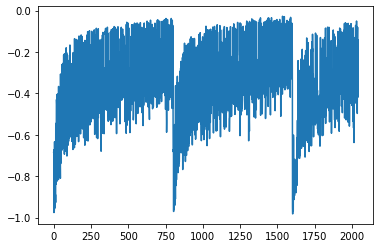

In [15]:
%matplotlib inline

plt.plot(range(len(reward_save)), reward_save)
plt.show

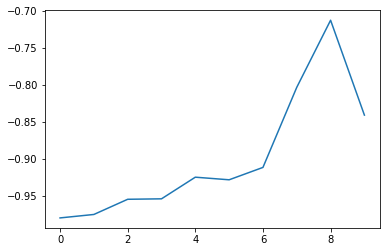

In [16]:
plt.plot(range(len(reward_validation_save)), reward_validation_save)

In [17]:
trainer.loss_actor_save

[tensor(3.2702, grad_fn=<MeanBackward0>),
 tensor(2.9770, grad_fn=<MeanBackward0>),
 tensor(2.7793, grad_fn=<MeanBackward0>),
 tensor(2.4843, grad_fn=<MeanBackward0>),
 tensor(2.1071, grad_fn=<MeanBackward0>),
 tensor(1.5442, grad_fn=<MeanBackward0>),
 tensor(-4.5923, grad_fn=<MeanBackward0>),
 tensor(-5.8652, grad_fn=<MeanBackward0>),
 tensor(-5.4988, grad_fn=<MeanBackward0>),
 tensor(-5.1608, grad_fn=<MeanBackward0>),
 tensor(1.2864, grad_fn=<MeanBackward0>),
 tensor(-5.0721, grad_fn=<MeanBackward0>),
 tensor(1.6967, grad_fn=<MeanBackward0>),
 tensor(2.4605, grad_fn=<MeanBackward0>),
 tensor(2.7364, grad_fn=<MeanBackward0>),
 tensor(3.7283, grad_fn=<MeanBackward0>),
 tensor(3.8890, grad_fn=<MeanBackward0>),
 tensor(3.7621, grad_fn=<MeanBackward0>),
 tensor(2.9361, grad_fn=<MeanBackward0>),
 tensor(1.7782, grad_fn=<MeanBackward0>),
 tensor(-7.9244, grad_fn=<MeanBackward0>),
 tensor(-0.6418, grad_fn=<MeanBackward0>),
 tensor(-11.1273, grad_fn=<MeanBackward0>),
 tensor(-1.5466, grad_fn=

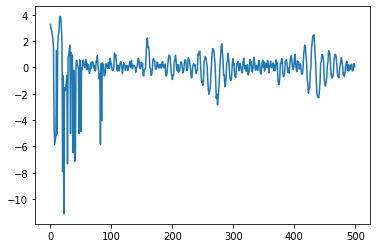

In [18]:
plt.plot(range(len(trainer.loss_actor_save)), trainer.loss_actor_save)

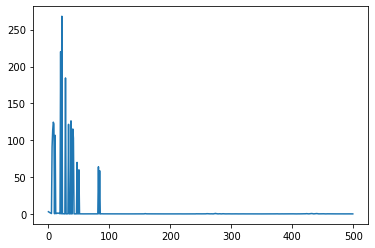

In [19]:
plt.plot(range(len(trainer.loss_critic_save)), trainer.loss_critic_save)